# Dane techniczne sprzętu

Obliczenia zostały wykonane na komputerze o następujących parametrach:

- Procesor: AMD Ryzen $7$ $4700$U ($8$ rdzeni, $8$ wątków),

- Pamięć RAM: $16$ GB $3200$ MHz

# Biblioteki

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from matplotlib import pyplot as plt
from sympy import Symbol, lambdify, sin
from decimal import Decimal, getcontext

# Pomocnicze funkcje

## Dokładność przybliżenia funkcji interpolowanej przez wielomian interpolujący 

Przyjmijmy następujące oznaczenia:

$f(x)$ - interpolowana funkcja (funkcja wzorcowa)

$W(x)$ - wielomian interpolujący (przybliżający funkcję wzorcową)

### Norma z różnicy

$||f(x)-W(x)||$

In [2]:
def abs_diff(f, W, xs):
    return [abs(f(x) - float(W(x))) for x in xs]

### Największa różnica

$max_k\{||f(x_k)-W(x_k)||\}$

In [3]:
def max_diff(f, W, xs):
    return max(abs_diff(f, W, xs))

### Suma kwadratów różnic

$\sum\limits_{i = 1}^{N} (f(x_i) - W(x_i))^2$

In [4]:
def sum_sq_diff(f, W, xs):
    return sum(d ** 2 for d in abs_diff(f, W, xs))

## Rysowanie wykresów

In [5]:
def plot_fn(fn, a, b, *, label='', title='Wykres', color='b', step=.1, ax=plt, use_decimal=False):
    n = int((b - a) / step) + 1
    xs = np.linspace(a, b, n)
    if use_decimal: xs = [Decimal(x) for x in xs]
    ax.plot(xs, [fn(x) for x in xs], color, label=label)
    if label: ax.legend(loc='best')
    
    if ax is plt:
        ax.title(title)
        ax.xlabel('x')
        ax.ylabel('y')
    else:
        ax.title.set_text(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    ax.grid()
    
    sns.despine()
    
def plot_interpolation(f, xs, ys, *, N=1000, show_errors_details=False, details_prec=6):
    W = hermite(xs, ys)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    
    # Compare interpolation polynomial to the original function
    use_decimal = isinstance(xs[0], Decimal)
    plot_fn(f, a, b, step=.01, color='#777', label='f', ax=ax[0], use_decimal=use_decimal)
    plot_fn(W, a, b, step=.01, label='Hermita', title='Wykres interpolacji', ax=ax[0], use_decimal=use_decimal)
    ax[0].scatter(xs, [y_list[0] for y_list in ys])
    
    # Create errors plot
    xs_ = np.linspace(a, b, N)
    if use_decimal: xs_ = [Decimal(x) for x in xs_]
    diffs = abs_diff(f, W, xs_)
    ax[1].scatter(xs_, diffs)
    ax[1].set_title("Wykres błędów")
    
    plt.show()
    
    if show_errors_details: 
        interpolation_error(f, W, 'Interpolacja Hermita', a, b, N, prec=details_prec, use_decimal=use_decimal)    
    
def compare_interpolation(f, xs, ys, *, N=1000, show_errors_details=False, details_prec=6):
    plot_interpolation()
    
def interpolation_error(f, W, label, a, b, N, *, prec=6, use_decimal=False):
    xs = np.linspace(a, b, N)
    if use_decimal: xs = [Decimal(x) for x in xs]
    
    diffs = abs_diff(f, W, xs)
    print(tabulate([
            ('Największy bezwzględny błąd', max(diffs)),
            ('Suma kwadratów różnic      ', sum(x ** 2 for x in diffs))
        ], [
            f'Interpolacja {label}'
        ], tablefmt='fancy_grid', floatfmt=f'.{prec}f')
    )

def chebyshev_nodes(a, b, n):
    xs = []
    for k in range(n, 0, -1):
        xs.append(.5 * (a + b) + .5 * (b - a) * math.cos((2 * k - 1) / (2 * n) * math.pi))
    return xs

## Wyznaczanie węzłów zgodnie z zerami wielomianu Czebyszewa

In [6]:
def chebyshev_nodes(a, b, n):
    xs = []
    for k in range(n, 0, -1):
        xs.append(.5 * (a + b) + .5 * (b - a) * math.cos((2 * k - 1) / (2 * n) * math.pi))
    return xs

# Interpolacja Hermite'a

In [7]:
def memoized(fn):
    cache = {}

    def inner(arg):
        if arg not in cache:
            cache[arg] = fn(arg)
        return cache[arg]
        
    return inner

@memoized
def factorial(n):
    if n in {0, 1}: return 1
    return n * factorial(n - 1)

def hermite(xs: list[int], ys: list[list[int]]):
    if len(xs) != len(ys):
        raise ValueError('The length of the xs list is different from from the length of the ys list')
    if not all(len(y_list) for y_list in ys):
        raise ValueError('Lists of function values and derivatives must be not empty')
    
    ms = [len(y_list) for y_list in ys]
    m = sum(ms) # Total number of coefficients
    n = m - 1  # Degree of a polynomial
    
    xs_ = []
    for i in range(len(xs)):
        xs_.extend([xs[i]] * ms[i])
    
    # Create a matrix of coefficients
    bs = [[None] * m for _ in range(m)]
    
    # Fill a matrix with known values
    i = 0
    for y_list in ys:
        for j in range(len(y_list)):
            for k in range(j + 1):
                bs[i][k] = y_list[k] / factorial(k)
            i += 1
            
    # Fill the remaining triangular part of a matrix
    for j in range(1, m):
        for i in range(j, m):
            if bs[i][j] is not None: 
                continue
            bs[i][j] = (bs[i][j - 1] - bs[i - 1][j - 1]) / (xs_[i] - xs_[i - j])
            
    # Rewrite coefficients to the linear array
    bs_ = [bs[i][i] for i in range(m)]
    
    # Create interpolating function
    def f(x):
        x_diffs = [x - xi for xi in xs]

        y = bs_[0]
        Pl = 1
        deg = 0  # Current Pl polynomial degree
        for i, mi in enumerate(ms):
            for _ in range(mi):
                deg += 1
                Pl *= x_diffs[i]
                y += bs_[deg] * Pl
                if deg == n:
                    return y
                
    return f

In [8]:
hermite([1, 2], [[1, 4], [3, 1, 1]])

<function __main__.hermite.<locals>.f(x)>

# Zadania

## Interpolowana funkcja

### Wzór funkcji

$\Large{f(x)=e^{-k\cdot{sin(mx)}}+k\cdot{sin(mx)}-1}$

gdzie $k=2$, $m=2$, $x\in[-\pi,2\pi]$

In [9]:
f = lambda x, k, m: math.e ** (-k * math.sin(m * x)) + k * math.sin(m * x) - 1

In [10]:
k = 2
m = 2
a = -math.pi
b = 2 * math.pi
x = [a, b]

g = lambda x: f(x, k, m)

### Wykres funkcji

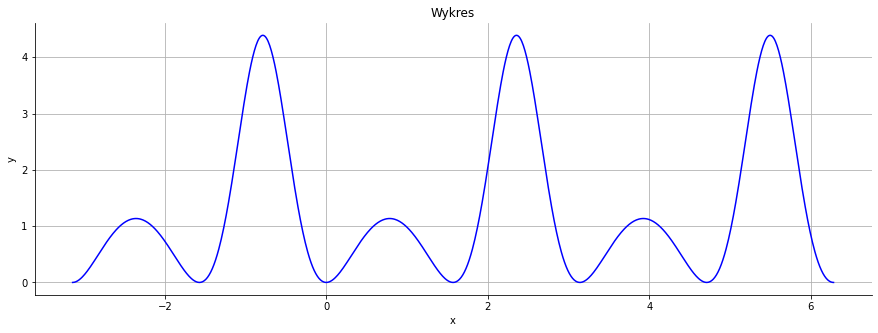

In [11]:
plt.figure(figsize=(15, 5))
plot_fn(g, a, b, step=.01)

## Interpolacja

###### Wyznaczanie funkcji pochodnych

In [12]:
from math import e
x = Symbol('x')
g0_ = e**(-2*sin(2*x))+2*sin(2*x)-1
g1_ = g0_.diff(x)
g2_ = g1_.diff(x)
g3_ = g2_.diff(x)

# Create callable functions from g1, g2, g3 objects
g1 = lambdify(x, g1_)
g2 = lambdify(x, g2_)
g3 = lambdify(x, g3_)
gs = [g, g1, g2, g3]

###### Funkcja g (zerowa pochodna)

In [13]:
g0_

2*sin(2*x) - 1 + 2.71828182845905**(-2*sin(2*x))

###### Funkcja g1 (pierwsza pochodna)

In [14]:
g1_

4*cos(2*x) - 4.0*cos(2*x)/2.71828182845905**(2*sin(2*x))

###### Funkcja g2 (druga pochodna)

In [15]:
g2_

-8*sin(2*x) + 8.0*sin(2*x)/2.71828182845905**(2*sin(2*x)) + 16.0*cos(2*x)**2/2.71828182845905**(2*sin(2*x))

###### Funkcja g3 (trzecia pochodna)

In [16]:
g3_

-16*cos(2*x) - 96.0*sin(2*x)*cos(2*x)/2.71828182845905**(2*sin(2*x)) - 64.0*cos(2*x)**3/2.71828182845905**(2*sin(2*x)) + 16.0*cos(2*x)/2.71828182845905**(2*sin(2*x))

###### Pozostałe

In [17]:
def derivatives(x, n):
    return list(map(lambda g: g(x), gs[:n+1]))

### Przykłady

#### Dla pochodnych $1$. rzędu

Największa dokładność dla $19$ węzłów

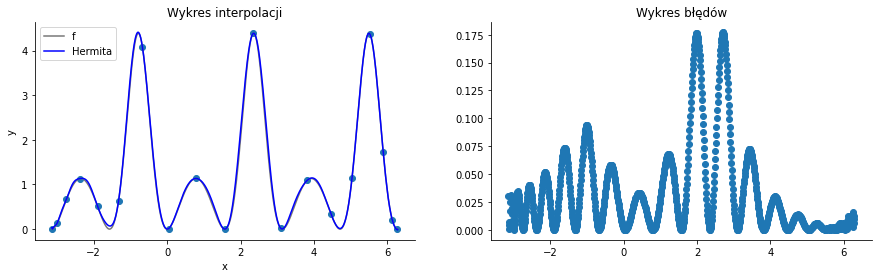

In [18]:
n = 19
xs = chebyshev_nodes(a, b, n)
ys = [derivatives(x, 1) for x in xs]  # Function values and their first-order derivatives

plot_interpolation(g, xs, ys)

Dla większej liczby węzłów, błąd szybko rośnie

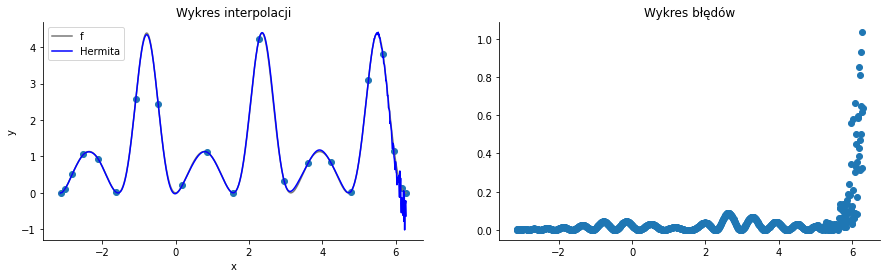

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            1.034106 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                            9.313506 │
╘═════════════════════════════╧═════════════════════════════════════╛


In [19]:
n = 21
xs = chebyshev_nodes(a, b, n)
ys = [derivatives(x, 1) for x in xs]  # Function values and their first-order derivatives

plot_interpolation(g, xs, ys, show_errors_details=True)

Baaaaaardzo szybko rośnie błąd 😄

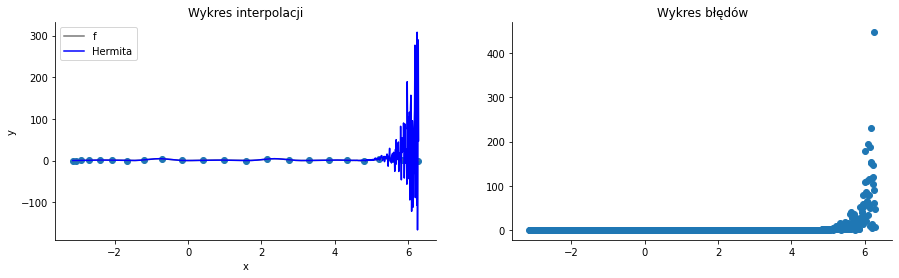

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                          447.354610 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                       589810.252949 │
╘═════════════════════════════╧═════════════════════════════════════╛


In [20]:
n = 25
xs = chebyshev_nodes(a, b, n)
ys = [derivatives(x, 1) for x in xs]  # Function values and their first-order derivatives

plot_interpolation(g, xs, ys, show_errors_details=True)

#### Porównanie liczby węzłów i rzędów pochodnych

###### Pochodne $0$. rzędu (wartości interpolowanej funkcji)

Najwyższa dokładność przybliżenia dla $41$ węzłów

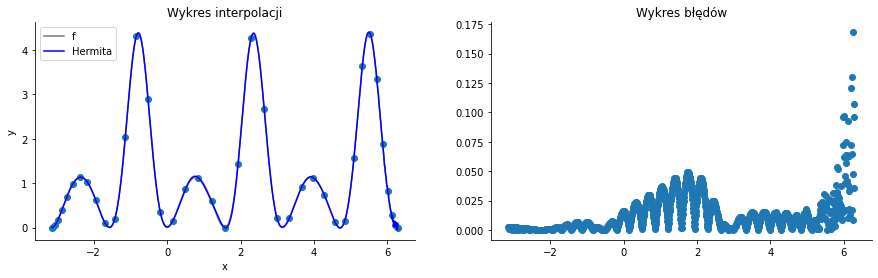

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            0.168165 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                            0.409430 │
╘═════════════════════════════╧═════════════════════════════════════╛


In [21]:
n = 41
xs = chebyshev_nodes(a, b, n)
ys = [derivatives(x, 0) for x in xs]  # Function values (without derivatives)

plot_interpolation(g, xs, ys, show_errors_details=True)

###### Pochodne $1$. rzędu (wartości interpolowanej funkcji i $1$. pochodne)

Najwyższa dokładność przybliżenia dla $19$ węzłów

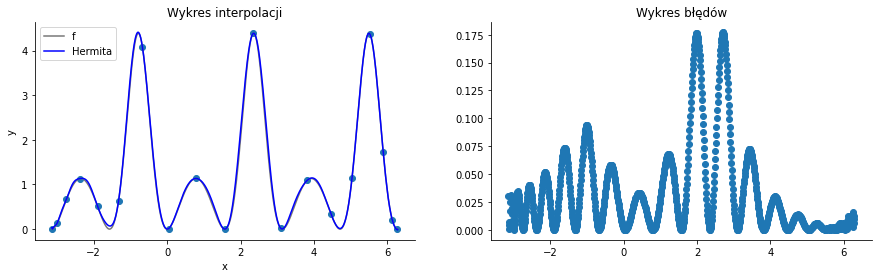

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            0.177169 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                            2.752221 │
╘═════════════════════════════╧═════════════════════════════════════╛


In [22]:
n = 19
xs = chebyshev_nodes(a, b, n)
ys = [derivatives(x, 1) for x in xs]  # Function values and their first order derivatives

plot_interpolation(g, xs, ys, show_errors_details=True)

###### Pochodne $2$. rzędu (wartości interpolowanej funkcji oraz $1$. i $2$. pochodne)

Najwyższa dokładność przybliżenia dla $13$ węzłów

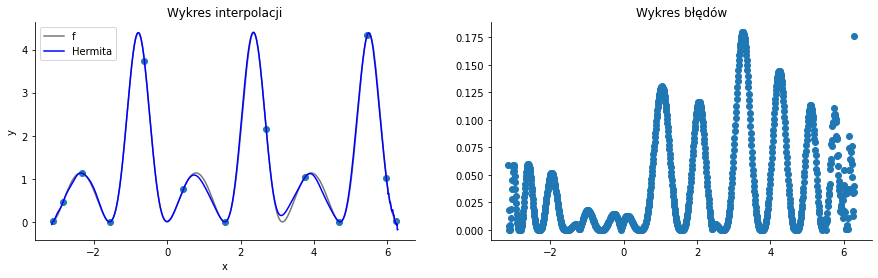

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            0.179524 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                            3.588540 │
╘═════════════════════════════╧═════════════════════════════════════╛


In [23]:
n = 13
xs = chebyshev_nodes(a, b, n)
ys = [derivatives(x, 2) for x in xs] # Function values and their first and second order derivatives

plot_interpolation(g, xs, ys, show_errors_details=True)

###### Pochodne $3$. rzędu (wartości interpolowanej funkcji oraz $1$. , $2$.i $3$. pochodne)

Najwyższa dokładność przybliżenia dla $7$ węzłów (choć w tym przypadku widać, że przybliżenie jest już bardzo niedokładne)

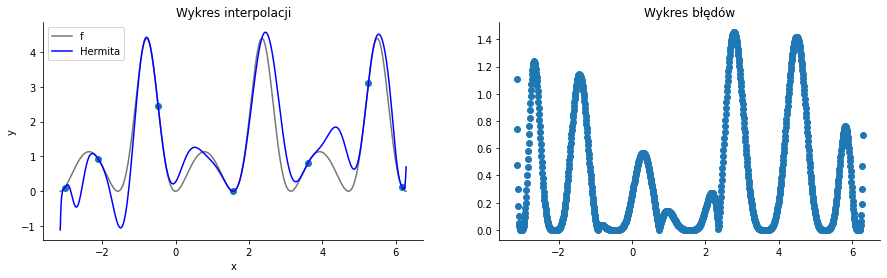

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            1.452684 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                          316.691615 │
╘═════════════════════════════╧═════════════════════════════════════╛


In [24]:
n = 7
xs = chebyshev_nodes(a, b, n)
ys = [derivatives(x, 3) for x in xs]  # Function values (without derivatives)

plot_interpolation(g, xs, ys, show_errors_details=True)

#### Implementacja z biblioteki `scipy`

Daje dużo bardziej dokładne wyniki.

In [25]:
from scipy.interpolate import CubicHermiteSpline

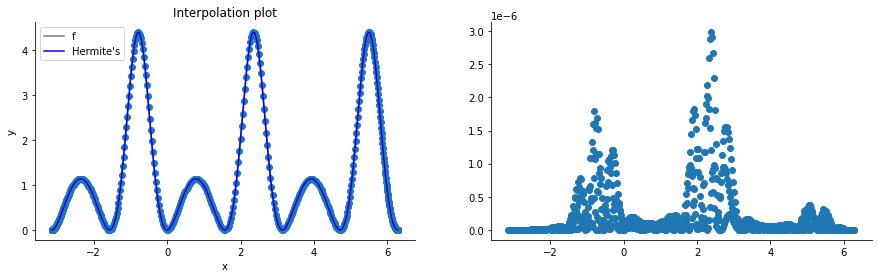

In [26]:
n = 500

xs = chebyshev_nodes(a, b, n)
ys = [g(x) for x in xs]
dydx = [g1(x) for x in xs]

N = 1000

W = CubicHermiteSpline(xs, ys, dydx)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# Compare interpolation polynomial to the original function
plot_fn(g, a, b, step=.01, color='#777', label='f', ax=ax[0])
plot_fn(W, a, b, step=.01, label='Hermite\'s', title='Interpolation plot', ax=ax[0])

# Create errors plot
xs_ = np.linspace(a, b, N)
diffs = abs_diff(g, W, xs_)
ax[1].scatter(xs_, diffs)
ax[0].scatter(xs, ys)
plt.show()

##### Dokładność obliczeń dla typu `Decimal` i ustawionej precyzji na $100$ znaków

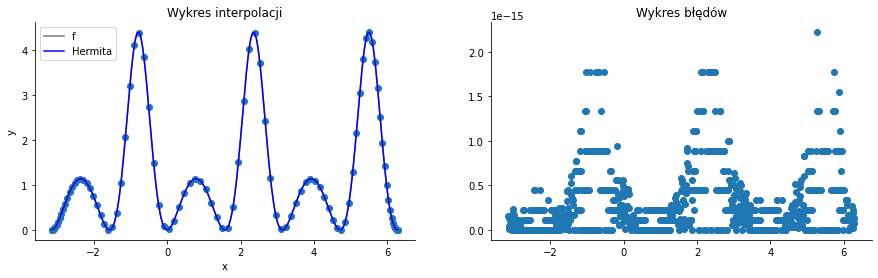

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │         0.0000000000000022204460493 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │         0.0000000000000000000000000 │
╘═════════════════════════════╧═════════════════════════════════════╛


In [27]:
getcontext().prec = 100

n = 100
xs = [Decimal(x) for x in chebyshev_nodes(a, b, n)]
ys = [[Decimal(y) for y in derivatives(float(x), 1)] for x in xs]

plot_interpolation(g, xs, ys, show_errors_details=True, details_prec=25)

# Zadanie

## Interpolacja dla różnej liczby węzłów

In [28]:
def test(n):
    pad = '=' * 25
    print(f'{pad} Dla węzłów równoodległych {pad}')
    xs = [Decimal(x) for x in np.linspace(a, b, n)]
    ys = [[Decimal(y) for y in derivatives(float(x), 1)] for x in xs]
    plot_interpolation(g, xs, ys, show_errors_details=True)

    print(f'{pad} Dla węzłów Czebyszewa {pad}')

    xs = [Decimal(x) for x in chebyshev_nodes(a, b, n)]
    ys = [[Decimal(y) for y in derivatives(float(x), 1)] for x in xs]
    plot_interpolation(g, xs, ys, show_errors_details=True)

###### Dla $n=3$

========================= Dla węzłów równoodległych =========================


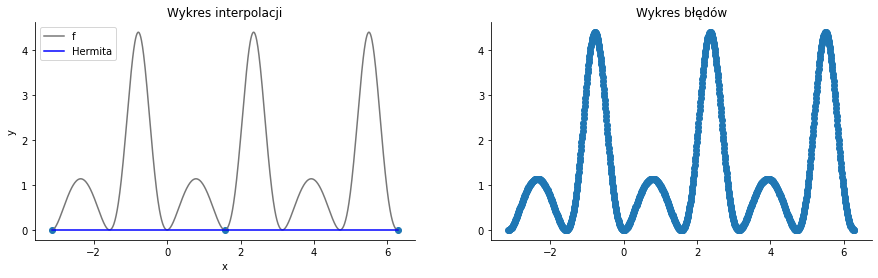

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            4.388914 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                         3376.823725 │
╘═════════════════════════════╧═════════════════════════════════════╛
========================= Dla węzłów Czebyszewa =========================


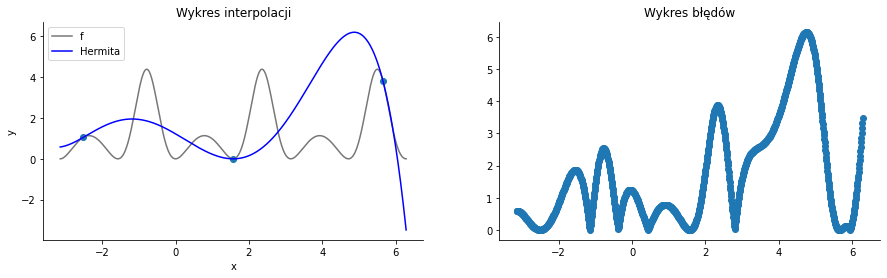

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            6.149714 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                         5654.884421 │
╘═════════════════════════════╧═════════════════════════════════════╛


In [29]:
test(3)

###### Dla $n=4$

========================= Dla węzłów równoodległych =========================


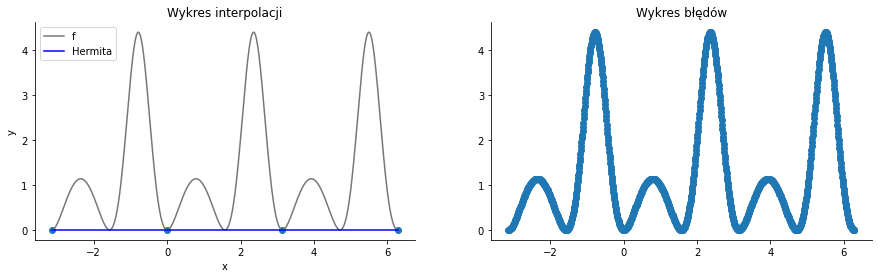

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            4.388914 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                         3376.823725 │
╘═════════════════════════════╧═════════════════════════════════════╛
========================= Dla węzłów Czebyszewa =========================


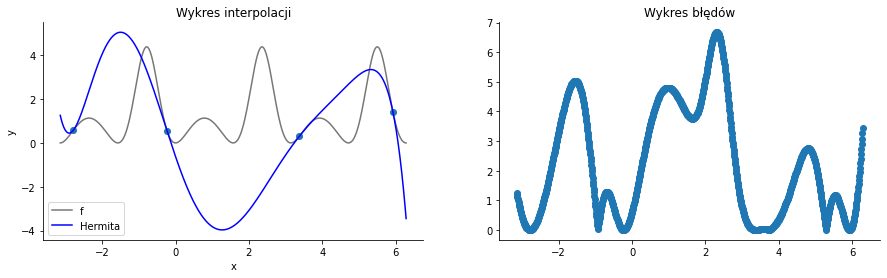

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            6.675620 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                         8587.325417 │
╘═════════════════════════════╧═════════════════════════════════════╛


In [30]:
test(4)

###### Dla $n=7$

========================= Dla węzłów równoodległych =========================


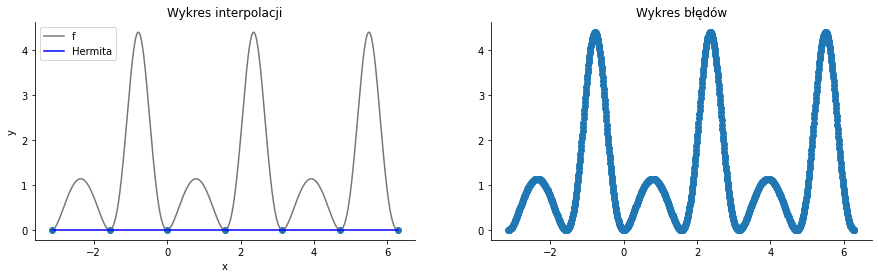

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            4.388914 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                         3376.823725 │
╘═════════════════════════════╧═════════════════════════════════════╛
========================= Dla węzłów Czebyszewa =========================


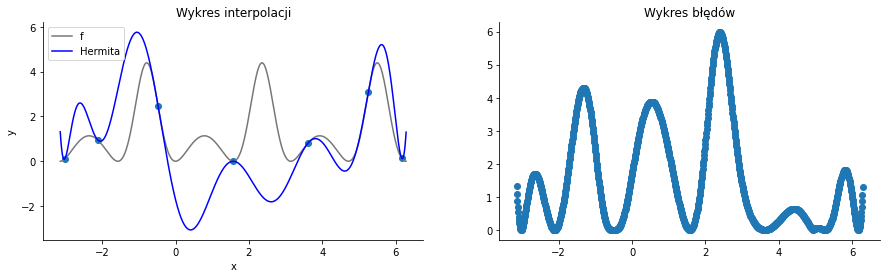

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            5.979030 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                         4751.202980 │
╘═════════════════════════════╧═════════════════════════════════════╛


In [31]:
test(7)

###### Dla $n=8$

========================= Dla węzłów równoodległych =========================


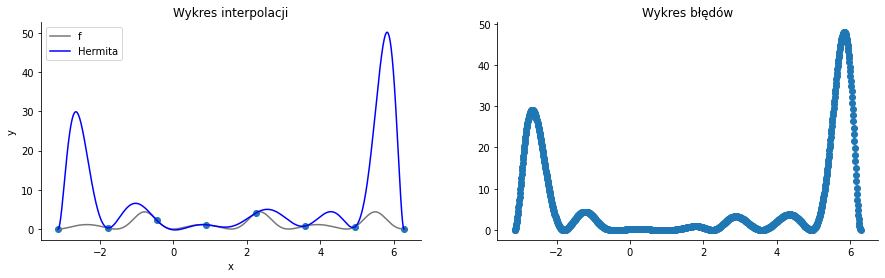

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                           47.932566 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                       157812.800963 │
╘═════════════════════════════╧═════════════════════════════════════╛
========================= Dla węzłów Czebyszewa =========================


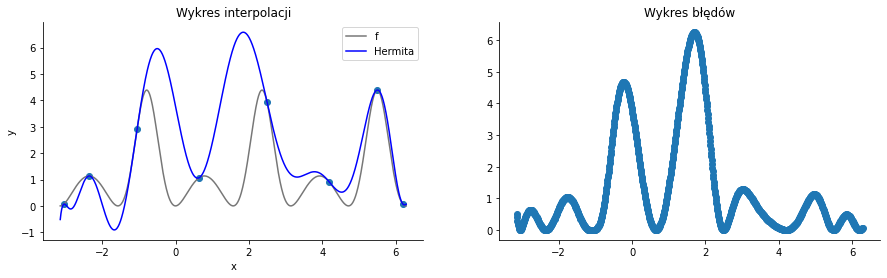

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            6.251001 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                         4353.613824 │
╘═════════════════════════════╧═════════════════════════════════════╛


In [32]:
test(8)

### Dla $n=9$

========================= Dla węzłów równoodległych =========================


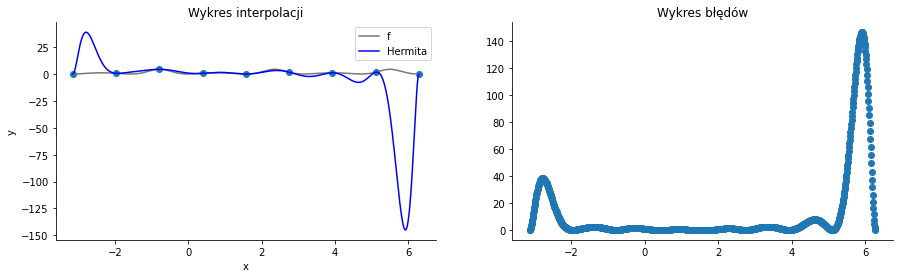

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                          146.474903 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                       962344.068177 │
╘═════════════════════════════╧═════════════════════════════════════╛
========================= Dla węzłów Czebyszewa =========================


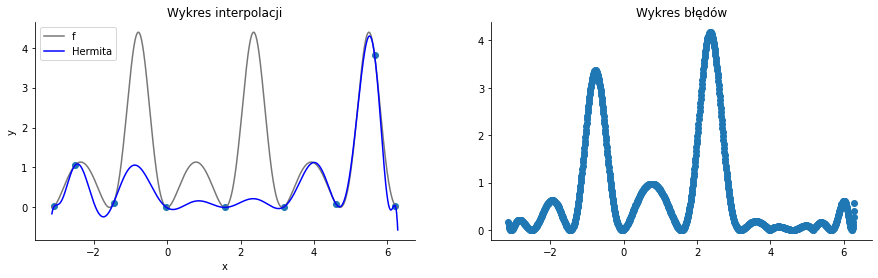

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            4.171509 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                         1597.317011 │
╘═════════════════════════════╧═════════════════════════════════════╛


In [33]:
test(9)

###### Dla $n=12$

========================= Dla węzłów równoodległych =========================


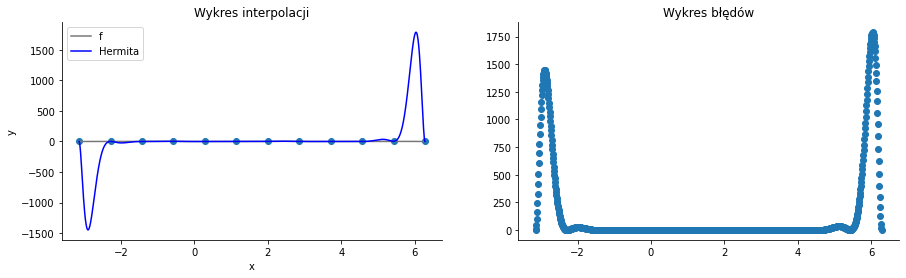

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                         1789.094864 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                    151024935.978973 │
╘═════════════════════════════╧═════════════════════════════════════╛
========================= Dla węzłów Czebyszewa =========================


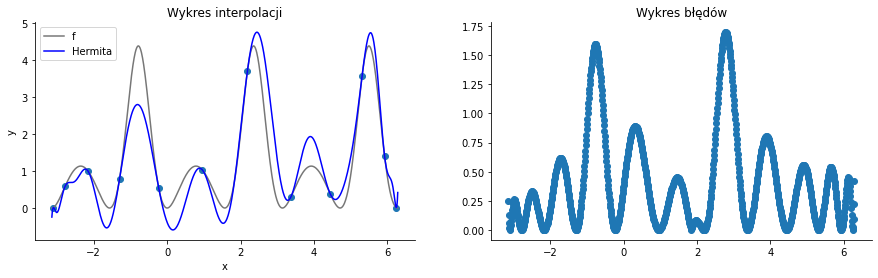

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            1.697556 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                          340.791079 │
╘═════════════════════════════╧═════════════════════════════════════╛


In [34]:
test(12)

###### Dla $n=16$

========================= Dla węzłów równoodległych =========================


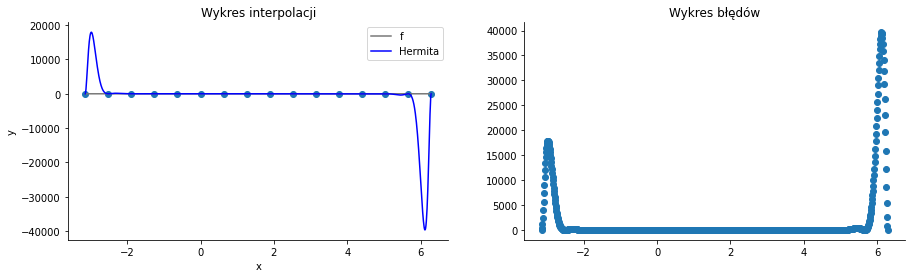

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                        39659.366213 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                  37749669918.505821 │
╘═════════════════════════════╧═════════════════════════════════════╛
========================= Dla węzłów Czebyszewa =========================


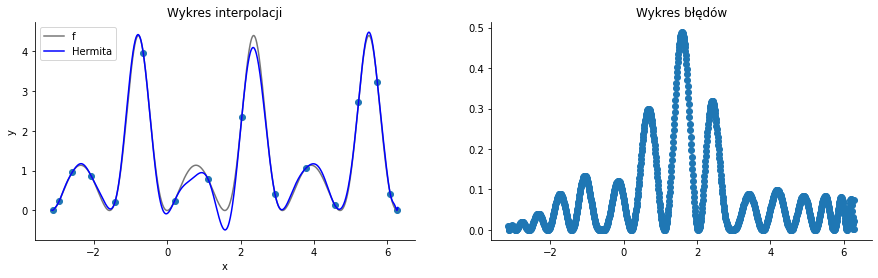

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            0.488424 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                           17.312047 │
╘═════════════════════════════╧═════════════════════════════════════╛


In [35]:
test(16)

###### Dla $n=21$

========================= Dla węzłów równoodległych =========================


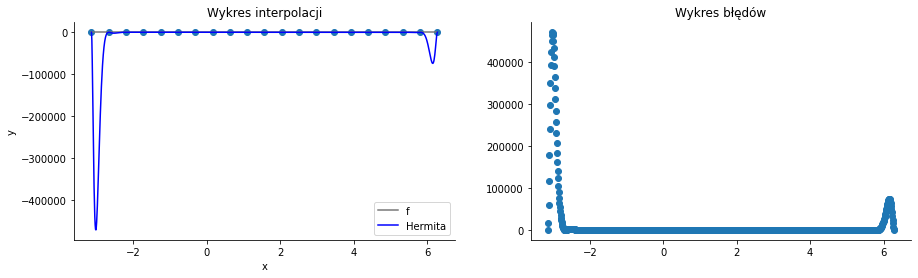

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                       471539.389526 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                3249834662755.250488 │
╘═════════════════════════════╧═════════════════════════════════════╛
========================= Dla węzłów Czebyszewa =========================


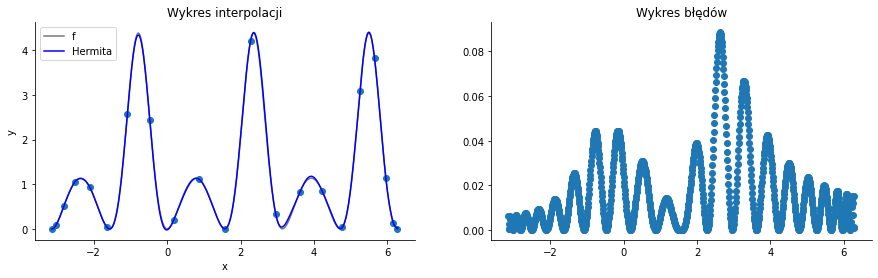

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            0.088615 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                            0.601661 │
╘═════════════════════════════╧═════════════════════════════════════╛


In [38]:
test(21)

###### Dla $n=100$

========================= Dla węzłów równoodległych =========================


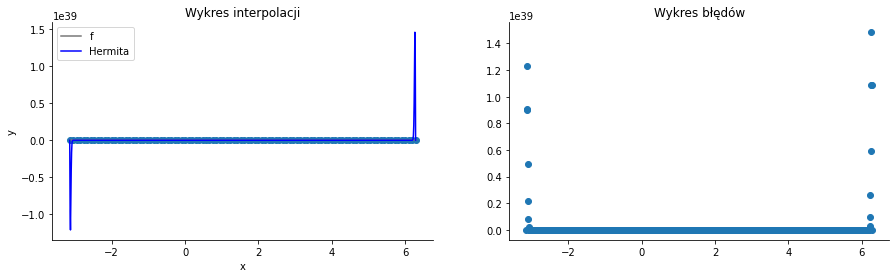

╒═════════════════════════════╤════════════════════════════════════════════════════════════════════════════════════════╕
│                             │                                                      Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪════════════════════════════════════════════════════════════════════════════════════════╡
│ Największy bezwzględny błąd │                                        1484269138904888088972812873317371346944.000000 │
├─────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────┤
│ Suma kwadratów różnic       │ 8456289696677029413389110548639024756777709342759064726185967487144762007355392.000000 │
╘═════════════════════════════╧════════════════════════════════════════════════════════════════════════════════════════╛
========================= Dla węzłów Czebyszewa =========================


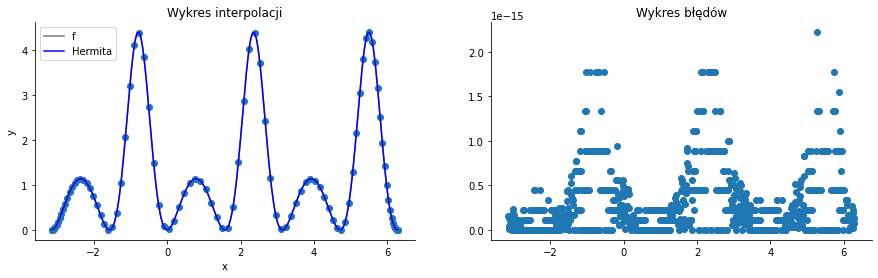

╒═════════════════════════════╤═════════════════════════════════════╕
│                             │   Interpolacja Interpolacja Hermita │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Największy bezwzględny błąd │                            0.000000 │
├─────────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów różnic       │                            0.000000 │
╘═════════════════════════════╧═════════════════════════════════════╛


In [39]:
test(100)